In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 20 # number of nodes
n = 1000 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
x, c = spo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=0)

## Optimization model

In [3]:
tsp_model = spo.model.tspModel(m)

Academic license - for non-commercial use only - expires 2021-08-20
Using license file C:\Users\Apocrypse\gurobi.lic


In [4]:
# solve
tsp_model.setObj(c[0])
sol, obj = tsp_model.solve()
print('Obj: {}'.format(obj))
tour = tsp_model.getTour(sol)
print(' -> '.join(map(str, tour)))

Obj: 2857.2200000000003
0 -> 2 -> 14 -> 6 -> 18 -> 5 -> 10 -> 9 -> 1 -> 4 -> 7 -> 19 -> 11 -> 8 -> 12 -> 3 -> 17 -> 15 -> 16 -> 13 -> 0


## Data Loader

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
tsp_dataset_train = spo.data.dataset.optDataset(tsp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.31it/s]


In [8]:
# get test data set
tsp_dataset_test = spo.data.dataset.optDataset(tsp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.86it/s]


In [9]:
# get data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(tsp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 10])

In [12]:
c.shape

torch.Size([32, 190])

In [13]:
w.shape

torch.Size([32, 190])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [17]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, tsp_model)

In [18]:
# training
twostage_model.fit(tsp_dataset_train.x, tsp_dataset_train.c)

In [19]:
# prediction
c_test_pred = twostage_model.predict(tsp_dataset_test.x)

In [20]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = tsp_dataset_test.c[i]
    z_true_i = tsp_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(tsp_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(tsp_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.75it/s]


Normalized true SPO Loss: 8.25%
Normalized unambiguous SPO Loss: 8.25%


In [21]:
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 357.64, 131.14, 228.19, 279.87, 312.85, 213.89, 318.21, 248.09, 858.84, 385.81, 428.65, 500.09, 124.78, 247.90, 337.31, 82.21, 158.04, 356.82, 148.16, 520.97, 268.93, 103.55, 257.91, 277.18, 273.17, 360.16, 96.57, 539.30, 328.01, 296.44, 388.47, 237.67, 172.10, 259.80, 146.11, 665.10, 168.05, 275.62, 446.60, 146.68, 132.90, 424.95, 301.42, 316.57, 231.14, 128.44, 258.23, 161.27, 188.87, 720.55, 332.48, 226.51, 219.79, 202.64, 522.55, 966.94, 362.93, 421.40, 430.88, 488.64, 332.25, 191.27, 232.21, 221.61, 329.17, 242.81, 184.92, 138.73, 408.30, 694.34, 515.38, 347.16, 223.04, 414.28, 127.93, 223.36, 410.55, 318.87, 306.05, 239.15, 351.04, 330.50, 268.82, 315.64, 189.82, 95.92, 194.04, 302.72, 250.32, 146.00, 232.90, 596.47, 231.00, 164.07, 400.17, 219.67, 335.94, 170.15, 180.26, 200.31, 497.82, 363.74, 81.59, 268.43, 315.98, 165.18, 149.01, 183.97, 353.84, 601.68, 97.21, 234.59, 552.41, 185.04, 225.44, 323.45, 390.36, 287.81, 465.51, 364.26, 466.92, 289.50, 223.

## Linear Regression from PyTorch 

In [22]:
from torch import nn

In [23]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m*(m-1)//2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [24]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [25]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)

In [26]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [27]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(tsp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(tsp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 5042.0381, True SPO Loss: 12.3815%, Unambiguous SPO Loss: 12.3815%
Epoch  20, Loss: 2619.3936, True SPO Loss:  9.5628%, Unambiguous SPO Loss:  9.5628%
Epoch  30, Loss: 2595.1636, True SPO Loss:  7.7230%, Unambiguous SPO Loss:  7.7230%
Epoch  40, Loss: 985.2240, True SPO Loss:  6.5252%, Unambiguous SPO Loss:  6.5252%
Epoch  50, Loss: 2472.4402, True SPO Loss:  5.6317%, Unambiguous SPO Loss:  5.6317%
Epoch  60, Loss: 1066.1353, True SPO Loss:  4.8629%, Unambiguous SPO Loss:  4.8629%
Epoch  70, Loss: 1370.2203, True SPO Loss:  4.4115%, Unambiguous SPO Loss:  4.4115%
Epoch  80, Loss: 561.3146, True SPO Loss:  3.8847%, Unambiguous SPO Loss:  3.8847%
Epoch  90, Loss: 931.5695, True SPO Loss:  3.6074%, Unambiguous SPO Loss:  3.6074%
Epoch 100, Loss: 846.1613, True SPO Loss:  3.2532%, Unambiguous SPO Loss:  3.2532%
Epoch 110, Loss: 703.3552, True SPO Loss:  2.9019%, Unambiguous SPO Loss:  2.9019%
Epoch 120, Loss: 700.7390, True SPO Loss:  2.7978%, Unambiguous SPO Loss:  2.7978

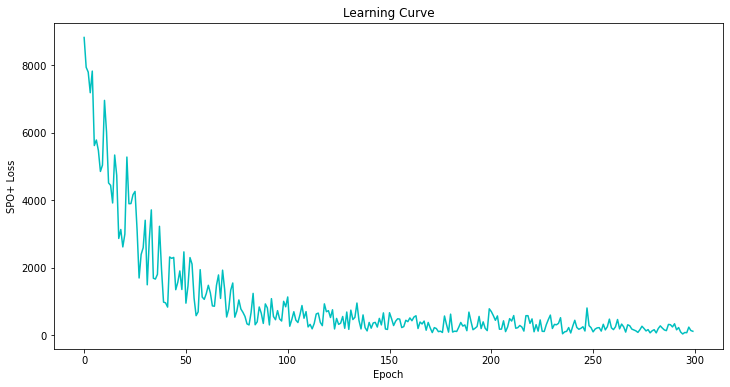

In [28]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

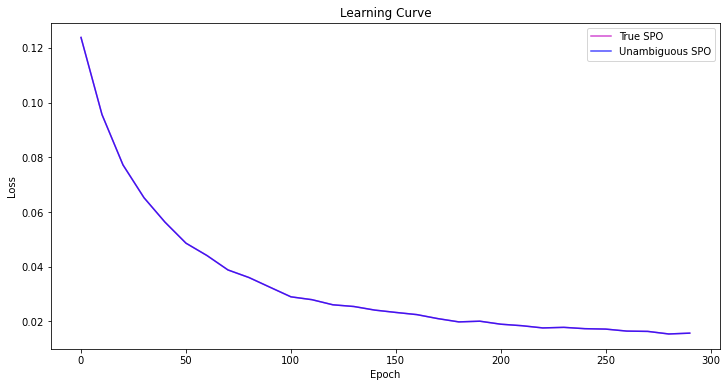

In [29]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [30]:
# evaluate
spoloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 1.57%
Normalized unambiguous SPO Loss: 1.57%


In [31]:
reg.eval()
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 357.64, 131.14, 228.19, 279.87, 312.85, 213.89, 318.21, 248.09, 858.84, 385.81, 428.65, 500.09, 124.78, 247.90, 337.31, 82.21, 158.04, 356.82, 148.16, 520.97, 268.93, 103.55, 257.91, 277.18, 273.17, 360.16, 96.57, 539.30, 328.01, 296.44, 388.47, 237.67, 172.10, 259.80, 146.11, 665.10, 168.05, 275.62, 446.60, 146.68, 132.90, 424.95, 301.42, 316.57, 231.14, 128.44, 258.23, 161.27, 188.87, 720.55, 332.48, 226.51, 219.79, 202.64, 522.55, 966.94, 362.93, 421.40, 430.88, 488.64, 332.25, 191.27, 232.21, 221.61, 329.17, 242.81, 184.92, 138.73, 408.30, 694.34, 515.38, 347.16, 223.04, 414.28, 127.93, 223.36, 410.55, 318.87, 306.05, 239.15, 351.04, 330.50, 268.82, 315.64, 189.82, 95.92, 194.04, 302.72, 250.32, 146.00, 232.90, 596.47, 231.00, 164.07, 400.17, 219.67, 335.94, 170.15, 180.26, 200.31, 497.82, 363.74, 81.59, 268.43, 315.98, 165.18, 149.01, 183.97, 353.84, 601.68, 97.21, 234.59, 552.41, 185.04, 225.44, 323.45, 390.36, 287.81, 465.51, 364.26, 466.92, 289.50, 223.

    Pred cost: 350.71, -352.10, 105.31, 247.41, -83.63, 80.95, 83.00, 62.24, 331.07, -103.09, 14.05, 135.49, -14.44, 158.75, -87.90, -153.16, 274.49, -101.53, -235.57, 310.06, 86.40, -144.31, 125.46, 112.53, -101.42, 198.74, -306.82, 265.61, 40.76, 87.01, 151.03, 87.00, -322.74, 180.26, -222.22, 394.08, -70.82, 79.43, 281.83, 161.15, -92.59, 310.78, -5.79, 326.26, 24.28, -77.82, -3.50, -255.09, -142.37, 157.83, 74.44, 80.76, -172.02, 48.76, -169.63, 460.94, 158.71, 164.59, -47.22, -143.01, 82.21, -56.90, -163.86, -227.37, 159.31, -139.36, 148.06, -216.42, 237.44, 111.44, 236.66, 115.66, -400.72, 361.85, -90.69, 151.55, 80.56, 203.80, 217.74, 101.85, 59.71, 117.29, 87.51, 251.71, -66.41, -409.81, 58.69, 238.18, 62.97, -117.81, 71.34, 468.78, 30.48, -146.37, 499.20, 54.57, 141.49, -295.11, 59.55, 181.58, 452.68, 249.86, -227.76, 151.28, 192.86, 5.12, -150.26, 243.64, 120.80, 471.53, -246.43, 69.60, 158.32, -272.63, 119.14, -3.05, 238.23, -63.93, 47.20, 77.56, 278.17, 243.41, 101.79, 96.7

    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, True obj: 2673.15
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 